In [5]:
import pandas as pd

# Load events_combined.csv
df = pd.read_csv("../data/interim/events_combined.csv")


In [6]:
# Check available player info
print(df.columns[df.columns.str.contains('player', case=False)])


Index(['player_name'], dtype='object')


In [10]:
import json
from pathlib import Path

In [11]:
# For example, using 'player_name' (you may need to adjust if player_id is not there)
df['player_name'] = df['player_name'].fillna("Unknown")
df['player_idx'] = df['player_name'].astype('category').cat.codes

# Create lookup table
player_index_lookup = df[['player_name', 'player_idx']].drop_duplicates()

# Create the folder if it doesn't exist
Path("../data/processed").mkdir(parents=True, exist_ok=True)
# Save it
player_index_lookup.to_csv("../data/processed/player_index_lookup.csv", index=False)


In [12]:
import arviz as az

# Load posterior
idata = az.from_netcdf("../data/interim/player_model_trace.nc")

# Extract mean player effects
player_effect_means = idata.posterior['player_effect'].mean(dim=["chain", "draw"]).values


In [14]:
import numpy as np

In [15]:
# Create a new DataFrame with player_idx and impact
impact_df = pd.DataFrame({
    'player_idx': np.arange(len(player_effect_means)),
    'player_xg_impact': player_effect_means
})

# Merge using 'player_idx' to align correctly
player_impact_df = pd.merge(player_index_lookup, impact_df, on='player_idx', how='inner')

# Save to processed folder
from pathlib import Path
Path("../data/processed").mkdir(parents=True, exist_ok=True)
player_impact_df.to_csv("../data/processed/player_impact.csv", index=False)

In [3]:
import pandas as pd 

In [16]:
import json
from pathlib import Path

# Load match JSON
with open("../data/raw/matches/43/3.json", "r", encoding="utf-8") as f:
    matches = json.load(f)

# Normalize to DataFrame
match_df = pd.json_normalize(matches)

# Keep only relevant columns
match_df = match_df[["match_id", 
                     "home_team.home_team_name", 
                     "away_team.away_team_name", 
                     "home_score", 
                     "away_score"]]

# Rename for convenience
match_df.columns = ["match_id", "home_team", "away_team", "home_score", "away_score"]


In [17]:
import pandas as pd

# Load files
df = pd.read_csv("../data/interim/events_combined.csv")
player_impact = pd.read_csv("../data/processed/player_impact.csv")

# Merge to include xG impact per player
df = df.merge(player_impact, on="player_name", how="left")

# Average xG impact per team per match
team_impact = (
    df.groupby(["match_id", "team_name"])["player_xg_impact"]
    .mean()
    .reset_index()
)

# Pivot to wide format: one row per match, columns for each team
impact_pivot = team_impact.pivot(index="match_id", columns="team_name", values="player_xg_impact").reset_index()

impact_pivot.head()


team_name,match_id,Argentina,Australia,Belgium,Brazil,Colombia,Costa Rica,Croatia,Denmark,Egypt,...,Russia,Saudi Arabia,Senegal,Serbia,South Korea,Spain,Sweden,Switzerland,Tunisia,Uruguay
0,7525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.00262,-0.008198,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7529,NaN,NaN,NaN,NaN,NaN,NaN,0.012675,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7530,NaN,-0.020183,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7531,-0.017154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7532,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.014959,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Add match outcome
def label_outcome(row):
    if row["home_score"] > row["away_score"]:
        return "win"
    elif row["home_score"] < row["away_score"]:
        return "loss"
    else:
        return "draw"

match_df["outcome"] = match_df.apply(label_outcome, axis=1)

# Now merge match_df with impact_pivot
final_df = match_df.merge(impact_pivot, on="match_id", how="left")

# Drop matches with missing player impact
final_df.dropna(inplace=True)

final_df


,match_id,home_team,away_team,home_score,away_score,outcome,Argentina,Australia,Belgium,Brazil,...,Russia,Saudi Arabia,Senegal,Serbia,South Korea,Spain,Sweden,Switzerland,Tunisia,Uruguay


In [19]:
# Check number of unique match IDs
print("match_df:", match_df['match_id'].nunique())
print("impact_pivot:", impact_pivot['match_id'].nunique())

# View a sample to compare
print("Sample match_df IDs:", match_df['match_id'].sort_values().unique()[:5])
print("Sample impact_pivot IDs:", impact_pivot['match_id'].sort_values().unique()[:5])


match_df: 64
impact_pivot: 64
Sample match_df IDs: [7525 7529 7530 7531 7532]
Sample impact_pivot IDs: [7525 7529 7530 7531 7532]


In [20]:
# Merge match outcome labels with team impact features
final_df = match_df.merge(impact_pivot, on="match_id", how="left")


# Check the result
final_df



,match_id,home_team,away_team,home_score,away_score,outcome,Argentina,Australia,Belgium,Brazil,...,Russia,Saudi Arabia,Senegal,Serbia,South Korea,Spain,Sweden,Switzerland,Tunisia,Uruguay
0,7585,Colombia,England,1,1,draw,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7570,England,Belgium,0,1,loss,NaN,NaN,-0.005095,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7586,Sweden,Switzerland,1,0,win,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.006961,0.036553,NaN,NaN
3,7557,Iran,Portugal,1,1,draw,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7542,Portugal,Morocco,1,0,win,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,7540,Russia,Egypt,3,1,win,NaN,NaN,NaN,NaN,...,0.006476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
60,8652,Russia,Croatia,2,2,draw,NaN,NaN,NaN,NaN,...,-0.013541,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61,7563,Denmark,France,0,0,draw,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,7556,Japan,Senegal,2,2,draw,NaN,NaN,NaN,NaN,...,NaN,NaN,0.01328,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Check where NaNs appear
final_df[final_df.isna().any(axis=1)].head()


,match_id,home_team,away_team,home_score,away_score,outcome,Argentina,Australia,Belgium,Brazil,...,Russia,Saudi Arabia,Senegal,Serbia,South Korea,Spain,Sweden,Switzerland,Tunisia,Uruguay
0,7585,Colombia,England,1,1,draw,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7570,England,Belgium,0,1,loss,NaN,NaN,-0.005095,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7586,Sweden,Switzerland,1,0,win,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.006961,0.036553,NaN,NaN
3,7557,Iran,Portugal,1,1,draw,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7542,Portugal,Morocco,1,0,win,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
# Fill NaN team impact values with 0 (assumes missing players had no measurable effect)
final_df_filled = final_df.fillna(0)
final_df_filled


,match_id,home_team,away_team,home_score,away_score,outcome,Argentina,Australia,Belgium,Brazil,...,Russia,Saudi Arabia,Senegal,Serbia,South Korea,Spain,Sweden,Switzerland,Tunisia,Uruguay
0,7585,Colombia,England,1,1,draw,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,7570,England,Belgium,0,1,loss,0.0,0.0,-0.005095,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
2,7586,Sweden,Switzerland,1,0,win,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,-0.006961,0.036553,0.0,0.0
3,7557,Iran,Portugal,1,1,draw,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
4,7542,Portugal,Morocco,1,0,win,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,7540,Russia,Egypt,3,1,win,0.0,0.0,0.000000,0.0,...,0.006476,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
60,8652,Russia,Croatia,2,2,draw,0.0,0.0,0.000000,0.0,...,-0.013541,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
61,7563,Denmark,France,0,0,draw,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
62,7556,Japan,Senegal,2,2,draw,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.01328,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0


In [23]:
# Save final match-level dataset for model training
final_df_filled.to_csv("../data/processed/final_match_model_data.csv", index=False)


In [39]:
# Step 1: Long-form DataFrame from pivot
long_df = impact_pivot.melt(id_vars="match_id", var_name="team_name", value_name="team_impact")

# Step 2: Create fresh df before merge
merged_df = final_df.copy()

# Merge home team impact
merged_df = merged_df.merge(
    long_df.rename(columns={"team_name": "home_team", "team_impact": "home_impact"}),
    on=["match_id", "home_team"],
    how="left"
)

# Merge away team impact
merged_df = merged_df.merge(
    long_df.rename(columns={"team_name": "away_team", "team_impact": "away_impact"}),
    on=["match_id", "away_team"],
    how="left"
)

# Step 3: Compute net impact
merged_df["net_impact"] = merged_df["home_impact"] - merged_df["away_impact"]


In [40]:
merged_df

,match_id,home_team,away_team,home_score,away_score,outcome,Argentina,Australia,Belgium,Brazil,...,Serbia,South Korea,Spain,Sweden,Switzerland,Tunisia,Uruguay,home_impact,away_impact,net_impact
0,7585,Colombia,England,1,1,draw,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.007525,-0.000023,-0.007502
1,7570,England,Belgium,0,1,loss,NaN,NaN,-0.005095,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000955,-0.005095,0.006050
2,7586,Sweden,Switzerland,1,0,win,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.006961,0.036553,NaN,NaN,-0.006961,0.036553,-0.043514
3,7557,Iran,Portugal,1,1,draw,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.005762,-0.000079,-0.005682
4,7542,Portugal,Morocco,1,0,win,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.033670,-0.014162,0.047832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,7540,Russia,Egypt,3,1,win,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.006476,0.009241,-0.002765
60,8652,Russia,Croatia,2,2,draw,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.013541,0.015429,-0.028970
61,7563,Denmark,France,0,0,draw,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.006296,0.026634,-0.032929
62,7556,Japan,Senegal,2,2,draw,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.011175,0.013280,-0.002106


In [45]:
model_df = merged_df.copy()
model_df["home_win"] = (model_df["outcome"] == "win").astype(int)


In [38]:
import pymc as pm
import arviz as az
import numpy as np

with pm.Model() as match_model:
    # Priors for intercept and coefficient
    intercept = pm.Normal("intercept", mu=0, sigma=2)
    beta = pm.Normal("beta", mu=0, sigma=2)
    
    # Logistic regression equation
    logit_p = intercept + beta * model_df["net_impact"].values
    p = pm.math.sigmoid(logit_p)
    
    # Likelihood
    outcome = pm.Bernoulli("outcome", p=p, observed=model_df["home_win"].values)
    
    # Sampling
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, target_accept=0.9)

    trace.to_netcdf("../models/match_outcome_model_trace.nc")



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 71 seconds.


In [48]:
import matplotlib.pyplot as plt

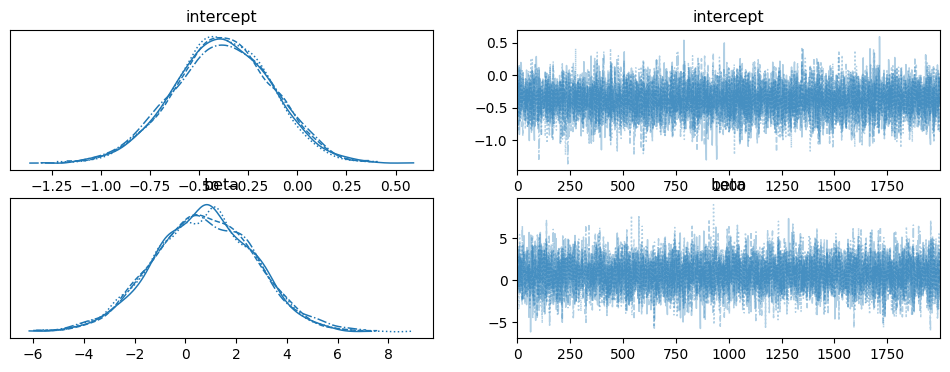

In [49]:
az.plot_trace(trace)
plt.show()


In [50]:
# Extract posterior samples
posterior = trace.posterior
intercept_samples = posterior["intercept"].values.flatten()
beta_samples = posterior["beta"].values.flatten()


In [51]:
# Net impact values
X = model_df["net_impact"].values

# Simulate posterior predictive probabilities
p_samples = 1 / (1 + np.exp(-(intercept_samples[:, None] + beta_samples[:, None] * X)))

# Mean win probability per match
home_win_probs = p_samples.mean(axis=0)

# Add to dataframe
model_df["predicted_home_win_prob"] = home_win_probs


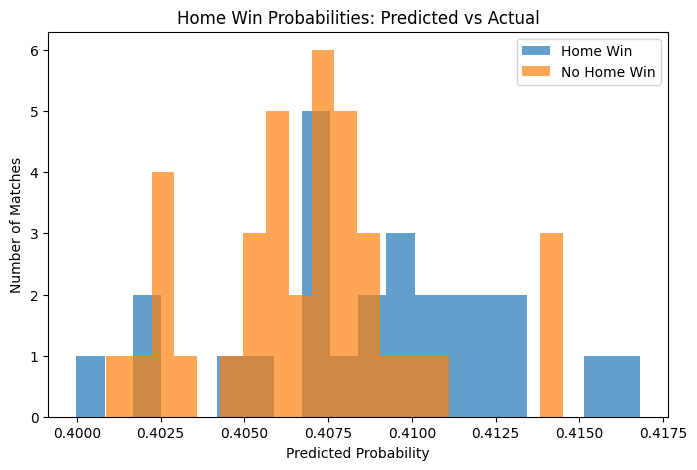

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(model_df[model_df["home_win"] == 1]["predicted_home_win_prob"], bins=20, alpha=0.7, label="Home Win")
plt.hist(model_df[model_df["home_win"] == 0]["predicted_home_win_prob"], bins=20, alpha=0.7, label="No Home Win")
plt.xlabel("Predicted Probability")
plt.ylabel("Number of Matches")
plt.title("Home Win Probabilities: Predicted vs Actual")
plt.legend()
plt.show()


In [53]:
import pymc as pm
import arviz as az

# Load the model trace
trace = az.from_netcdf("../models/match_outcome_model_trace.nc")


In [54]:
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np

# Load processed match-level data
model_df = pd.read_csv("../data/processed/final_match_model_data.csv")

# Encode outcomes
outcome_map = {"loss": 0, "draw": 1, "win": 2}
y = model_df["outcome"].map(outcome_map).values
X = model_df["net_impact"].values

# Rebuild model
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, sigma=1)
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    mu = alpha + beta * X
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    
    outcome_obs = pm.OrderedLogistic("outcome_obs", eta=mu, cutpoints=[0.5, 1.5], observed=y)

    trace = az.from_netcdf("../models/match_outcome_model_trace.nc")

# Generate posterior predictive samples
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["outcome_obs"])

# Save posterior predictive trace
pp_trace = az.from_dict(posterior_predictive=ppc)
pp_trace.to_netcdf("../models/match_outcome_post_pred.nc")


KeyError: 'net_impact'

In [56]:
import pandas as pd

# Load your existing data
df = pd.read_csv("../data/processed/final_match_model_data.csv")

# Step 1: Melt to long format
long_df = df.melt(
    id_vars=["match_id", "home_team", "away_team", "home_score", "away_score", "outcome"],
    var_name="team_name",
    value_name="player_xg_impact"
)

# Step 2: Get home team impact
df_home = long_df[["match_id", "team_name", "player_xg_impact"]].copy()
df_home = df_home.rename(columns={"team_name": "home_team", "player_xg_impact": "home_impact"})

# Step 3: Merge with df on match_id and home_team
df_final = df.merge(df_home, on=["match_id", "home_team"], how="left")

# Step 4: Get away team impact
df_away = long_df[["match_id", "team_name", "player_xg_impact"]].copy()
df_away = df_away.rename(columns={"team_name": "away_team", "player_xg_impact": "away_impact"})

# Step 5: Merge with df_final on match_id and away_team
df_final = df_final.merge(df_away, on=["match_id", "away_team"], how="left")

# Step 6: Compute net impact
df_final["net_impact"] = df_final["home_impact"] - df_final["away_impact"]

# Step 7: Save
df_final.to_csv("../data/processed/final_match_model_data_ready.csv", index=False)


In [57]:
model_df = pd.read_csv("../data/processed/final_match_model_data_ready.csv")
X = model_df["net_impact"].values
y = model_df["outcome"].map({"loss": 0, "draw": 1, "win": 2}).values


In [62]:
!pip install --upgrade arviz


   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
    --------------------------------------- 0.0/1.7 MB 653.6 kB/s eta 0:00:03
   -- ------------------------------------- 0.1/1.7 MB 1.3 MB/s eta 0:00:02
   ------ --------------------------------- 0.3/1.7 MB 2.0 MB/s eta 0:00:01
   ------------ --------------------------- 0.5/1.7 MB 3.2 MB/s eta 0:00:01
   ---------------------- ----------------- 0.9/1.7 MB 4.9 MB/s eta 0:00:01
   --------------------------- ------------ 1.2/1.7 MB 4.9 MB/s eta 0:00:01
   -------------------------------------- - 1.6/1.7 MB 6.0 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 5.6 MB/s eta 0:00:00
  Attempting uninstall: arviz
    Found existing installation: arviz 0.21.0
    Uninstalling arviz-0.21.0:
      Successfully uninstalled arviz-0.21.0



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [65]:
import pymc as pm
import arviz as az
import numpy as np

# Rebuild model
with pm.Model() as model:
    beta = pm.Normal("beta", mu=0, sigma=1)
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    mu = alpha + beta * X
    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    
    outcome_obs = pm.OrderedLogistic("outcome_obs", eta=mu, cutpoints=[0.5, 1.5], observed=y)

    trace = az.from_netcdf("../models/match_outcome_model_trace.nc")

# Generate posterior predictive samples and return as InferenceData directly
with model:
    ppc_idata = pm.sample_posterior_predictive(trace, var_names=["outcome_obs"], return_inferencedata=True)

# ✅ Save it directly — no wrapping with az.from_dict or az.from_pymc needed
ppc_idata.to_netcdf("../models/match_outcome_post_pred.nc")


Sampling: [alpha, outcome_obs]


Output()

'../models/match_outcome_post_pred.nc'